In [1]:
import numpy as np
import torch
from torch import nn  
import time 
import os  
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
## import self defined functions
from sys import path 
# insert at 1, 0 is the script path (or '' in REPL)
path.insert(1, '/tigress/cw55/local/python_lib')
from cg_funcs import global_mean_xarray
root = '/tigress/cw55/work/2022_radi_nn/NN_AM4'
path.insert(1,  root+'/work')
import work.lw_csaf_Li5Relu_cluster.train_script as lwcsaf
import work.lw_af_Li5Relu.train_script00 as lwaf

In [3]:
plt.rcParams['font.size'] = '8'

In [4]:
from get_AM4_data_lw import get_AM4_data_lw
######################################################
# common functions to split the training and test data
from NNRTMC_lw_utils import  split_train_test_sample, \
draw_batches, data_std_normalization, print_key_results, return_exp_dir
    
from diag_utils import batch_index_sta_end, pred_NN_batch,\
create_6tiles_lw,regrid_6tile2latlon

In [5]:
if __name__ == '__main__': 
    torch.cuda.set_device(0) # select gpu_id, default 0 means the first GPU
    device = f'cuda:{torch.cuda.current_device()}'
    ######################################################
    # set exp name and runs
    Exp_name = [
        'lw_csaf_Li5Relu_cluster',
        'lw_af_Li5Relu',
    ]
    Exp_name_model_dict = {
        'lw_csaf_Li5Relu_cluster': lwcsaf,
        'lw_af_Li5Relu': lwaf,
    }
    sky_cond = {
        'lw_csaf_Li5Relu_cluster': 'csaf',
        'lw_af_Li5Relu': 'af',
    }
    work_dir = root+'/work/' 
    # file list AM4 runs
    out_filelist = [f'/scratch/gpfs/rm5768/ml/20000101.fluxes.tile{_}.nc' for _ in range(1,7)]
    inp_filelist = [f'/scratch/gpfs/rm5768/ml/20000101.new_offline_input.tile{_}.nc' for _ in range(1,7)]

    hybrid_p_sigma_para = xr.open_dataset('/tigress/cw55/data/NNRTMC_dataset/AM4_pk_bk_202207.nc')
    A_k = hybrid_p_sigma_para.ak.values[None,:]
    B_k = hybrid_p_sigma_para.bk.values[None,:] 

In [6]:
month_sel = None
day_sel = [15]

In [7]:
%%time
predi = {}
error = {}
eng_err = {}
NN_model = {}
ds_regrid = {}

for mo in Exp_name:
    ######################################################
    # create dir for first run or load restart file
    run_num, exp_dir = return_exp_dir(work_dir, mo, create_dir=False)
    # load restart file
    PATH_last =  exp_dir+f'/restart.{run_num-1:02d}.pth'
    restart_data = torch.load(PATH_last)  # load exist results and restart training
    print(f'load: {PATH_last}')
    # read training dataset, nor_para, model parameteres
    nor_para = restart_data['nor_para']
    model_state_dict = restart_data['model_state_dict']
    # read data
    input_array_ori, output_array_ori, ds_coords = \
    get_AM4_data_lw(out_filelist, inp_filelist, condition=sky_cond[mo], 
                    month_sel = month_sel, day_sel = day_sel, return_coords=True) 
    # initialize model
    if mo == 'lw_af_Li5Relu':
        NN_model[mo] = Exp_name_model_dict[mo].ResNNRTMC(device, nor_para, A_k, B_k, input_array_ori.shape[1],model_state_dict)  
    else:
        NN_model[mo] = Exp_name_model_dict[mo].ResNNRTMC(device, nor_para, A_k, B_k, model_state_dict)  
     
    # normalize data via saved nor_para in restart file
    nor_para, input_array, output_array   = data_std_normalization(input_array_ori, output_array_ori, nor_para)
    
    # try NN on test dataset  
    predi[mo], eng_err[mo] = pred_NN_batch(input_array, output_array, NN_model[mo], nor_para, device)
    error[mo] = predi[mo] - output_array_ori
    predi[mo][:,3:] = predi[mo][:,3:]*86400 # HR K/s >> K/day
    error[mo][:,3:] = error[mo][:,3:]*86400 # HR K/s >> K/day
    # create 6-tile files for output and regrid 
    NN_output_name = 'NN_20000101.fluxes' 
    subprocess.run([f'mkdir -p {exp_dir}/NN_pred'], shell=True, check=True)
    var_list = create_6tiles_lw(ds_coords, predi[mo], error[mo], exp_dir, NN_output_name)
    regrid_file_path = regrid_6tile2latlon(var_list,exp_dir,root, NN_output_name)
    # open regridded file
    with  xr.open_dataset(regrid_file_path) as ds:
        ds_regrid[mo] = ds.load().rename({'grid_yt':'lat', 'grid_xt':'lon'})

load: /tigress/cw55/work/2022_radi_nn/NN_AM4/work/lw_csaf_Li5Relu_cluster/restart.04.pth
Data selection:
    Month: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 
    Day: [15] 
Reading data... 0 1 2 3 4 5 Done.
Total data size: 5308416
Creating 6 tiles ...   Done.
Calling fregrid in subshell ... 
Done.
load: /tigress/cw55/work/2022_radi_nn/NN_AM4/work/lw_af_Li5Relu/restart.04.pth
Data selection:
    Month: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 
    Day: [15] 
Reading data... 0 1 2 3 4 5 Done.
Total data size: 5308416
Creating 6 tiles ...   Done.
Calling fregrid in subshell ... 
Done.
CPU times: user 39.6 s, sys: 21.2 s, total: 1min
Wall time: 2min 52s


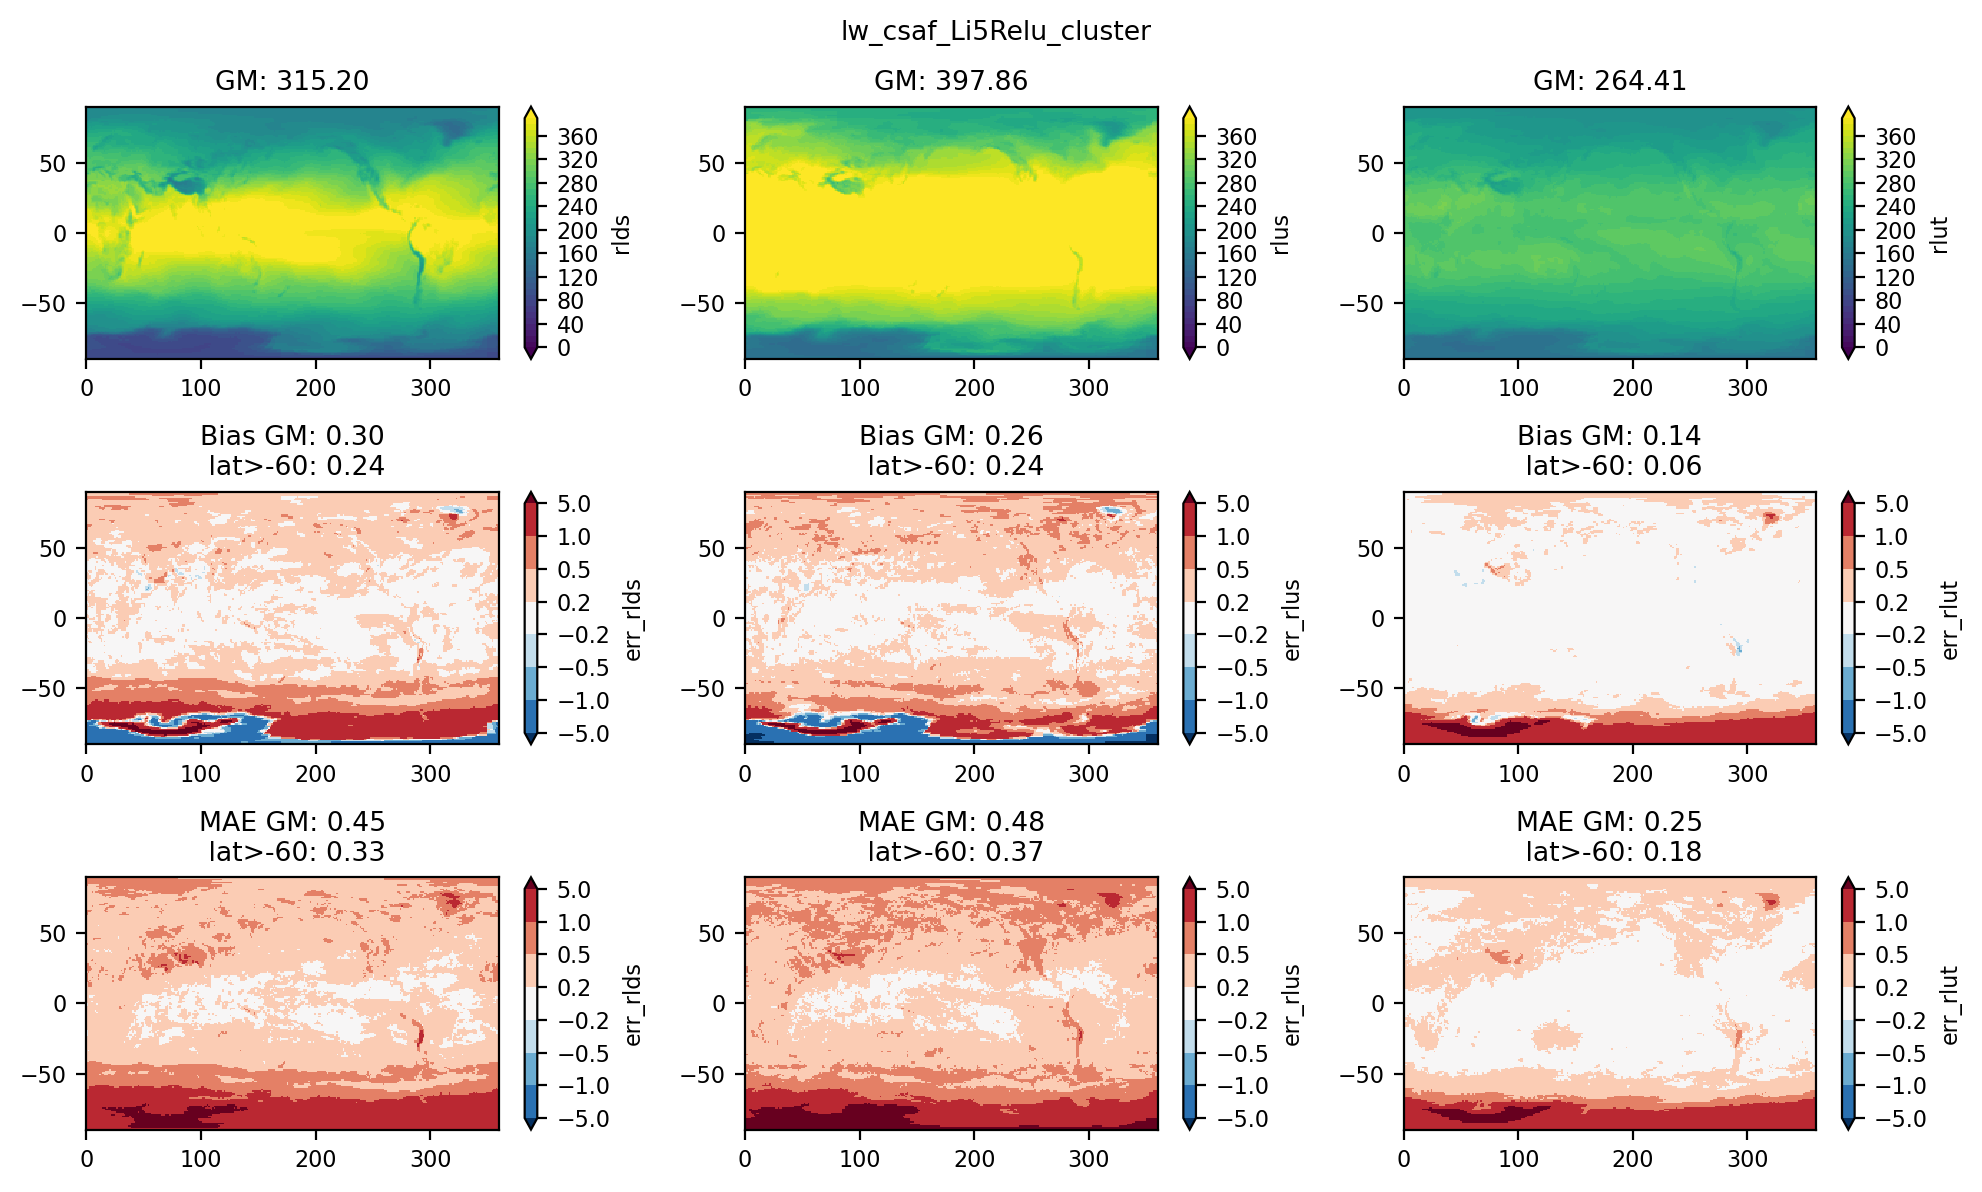

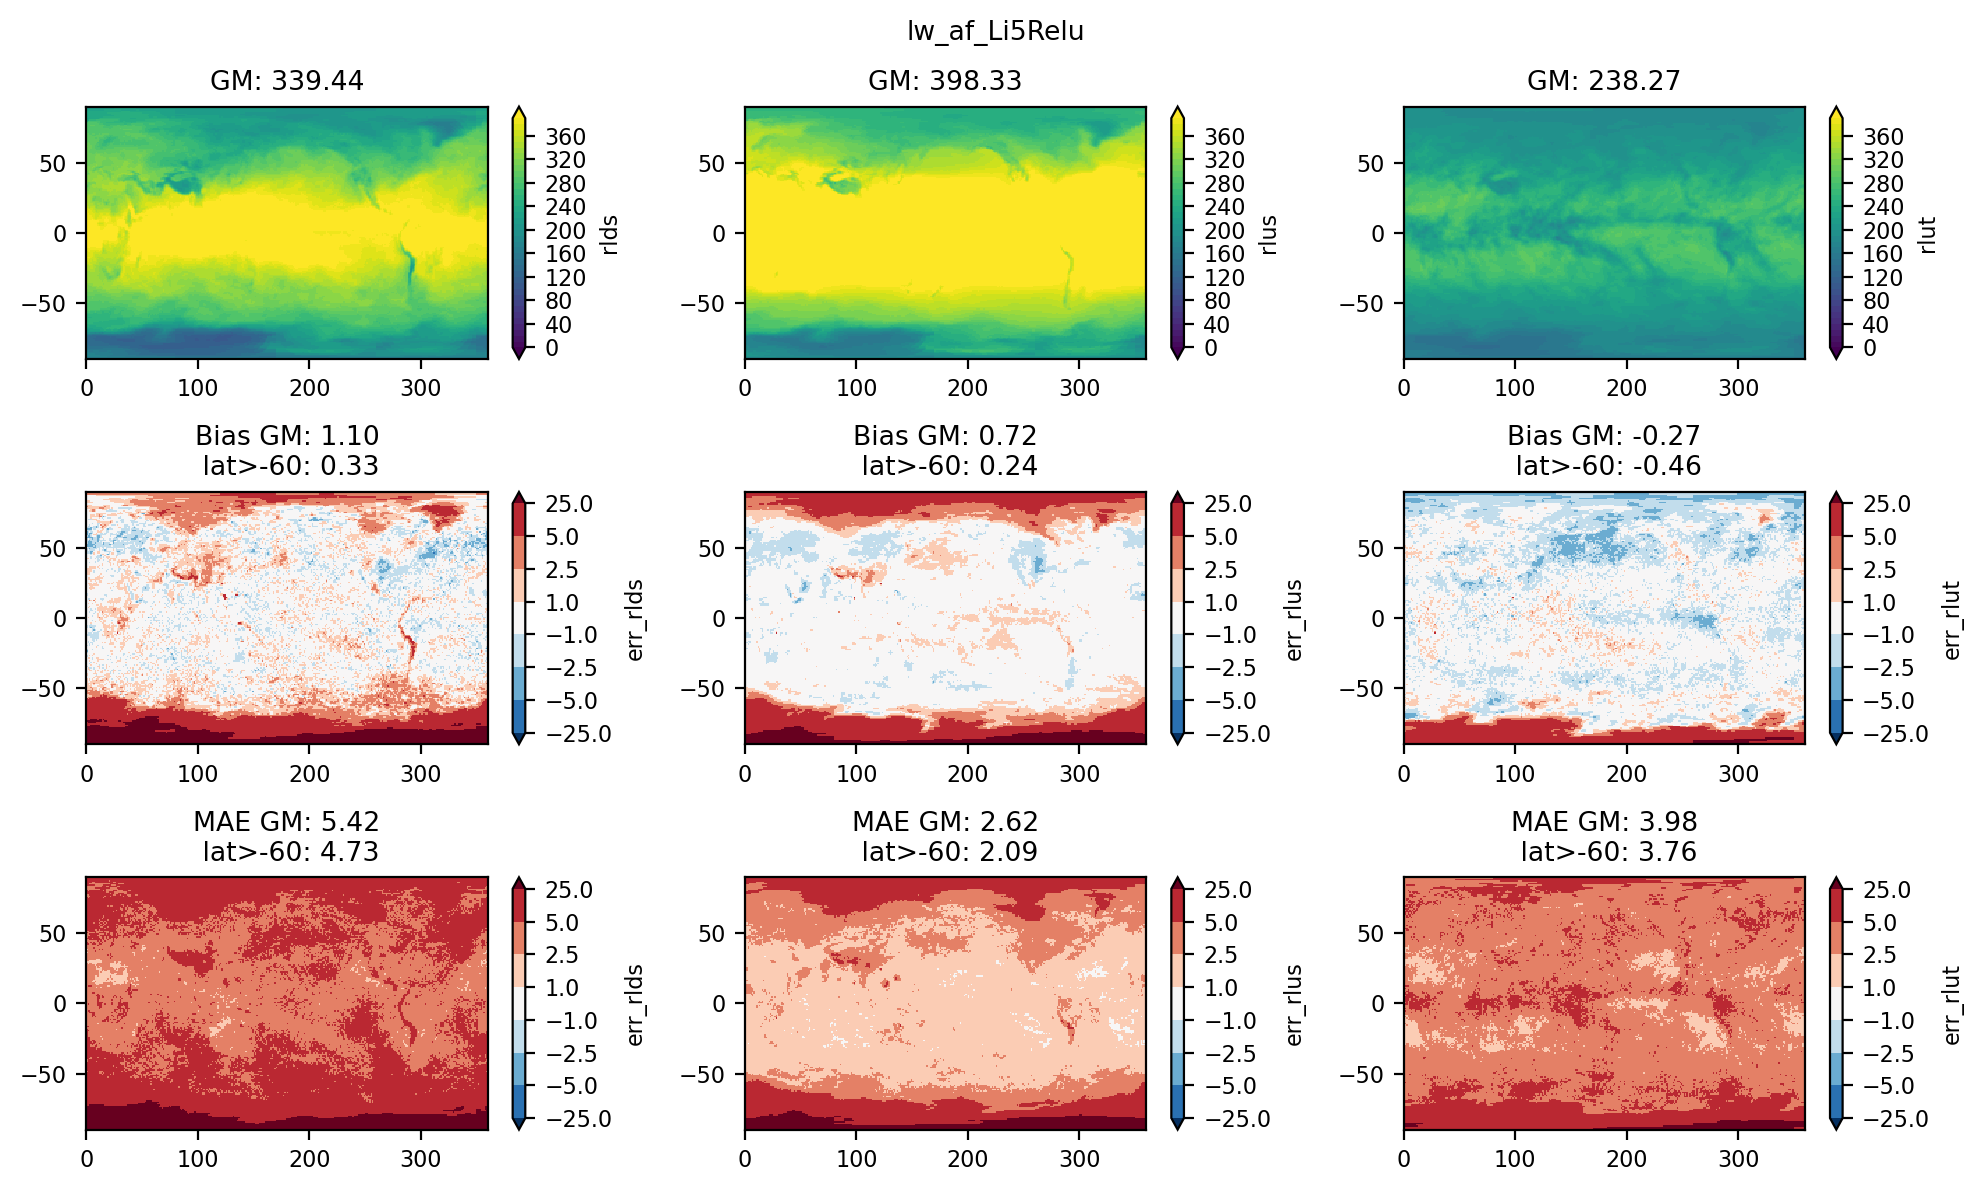

In [8]:
for mo in Exp_name:
    ds_plot = ds_regrid[mo]
    fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(10,6),dpi=200)
    axs = axs.flatten()
    var1 = ['rlds','rlus','rlut']
    level = np.arange(0,400,10)
    for i in range(3):
        ax=axs[i]
        da = ds_plot[var1[i]].mean('time')
        da.plot(ax=ax, levels=level, extend='both') 
        ax.set_title(f'GM: {global_mean_xarray(da).values:4.2f}')
    level = np.array([-5,-1,-0.5,-0.2,0.2,0.5,1,5])
    if mo == 'lw_af_Li5Relu': level = level*5
    for i in range(3):
        ax=axs[i+3]
        da = ds_plot['err_'+var1[i]].mean('time')
        da.plot(ax=ax, levels=level, extend='both')   
        ax.set_title(f'Bias GM: {global_mean_xarray(da).values:4.2f}'\
                     +f'\n lat>-60: {global_mean_xarray(da.sel(lat=slice(-60,90))).values:4.2f}')
    for i in range(3):
        ax=axs[i+6]
        da = abs(ds_plot['err_'+var1[i]]).mean('time')
        da.plot(ax=ax, levels=level, extend='both')    
        ax.set_title(f'MAE GM: {global_mean_xarray(da).values:4.2f}'\
                     +f'\n lat>-60: {global_mean_xarray(da.sel(lat=slice(-60,90))).values:4.2f}') 
    for ax in axs:
        ax.set(xlabel=None,ylabel=None)
    plt.suptitle(mo)
    fig.tight_layout()

In [9]:
z_lev = [ 1.      ,    4.      ,    8.186021,   13.788865,   20.917952,
         29.836408,   41.217896,   55.792215,   74.201906,   97.047864,
        124.966648,  158.549553,  198.396959,  245.027221,  298.888576,
        360.040179,  427.458025,  498.243573,  568.220535,  633.836047,
        693.266329,  745.991986,  792.097373,  831.921945,  865.977814,
        894.872525,  919.22792 ,  939.565932,  956.402132,  970.147661,
        981.130665,  989.68    ,  995.9     ,  1000.     ]

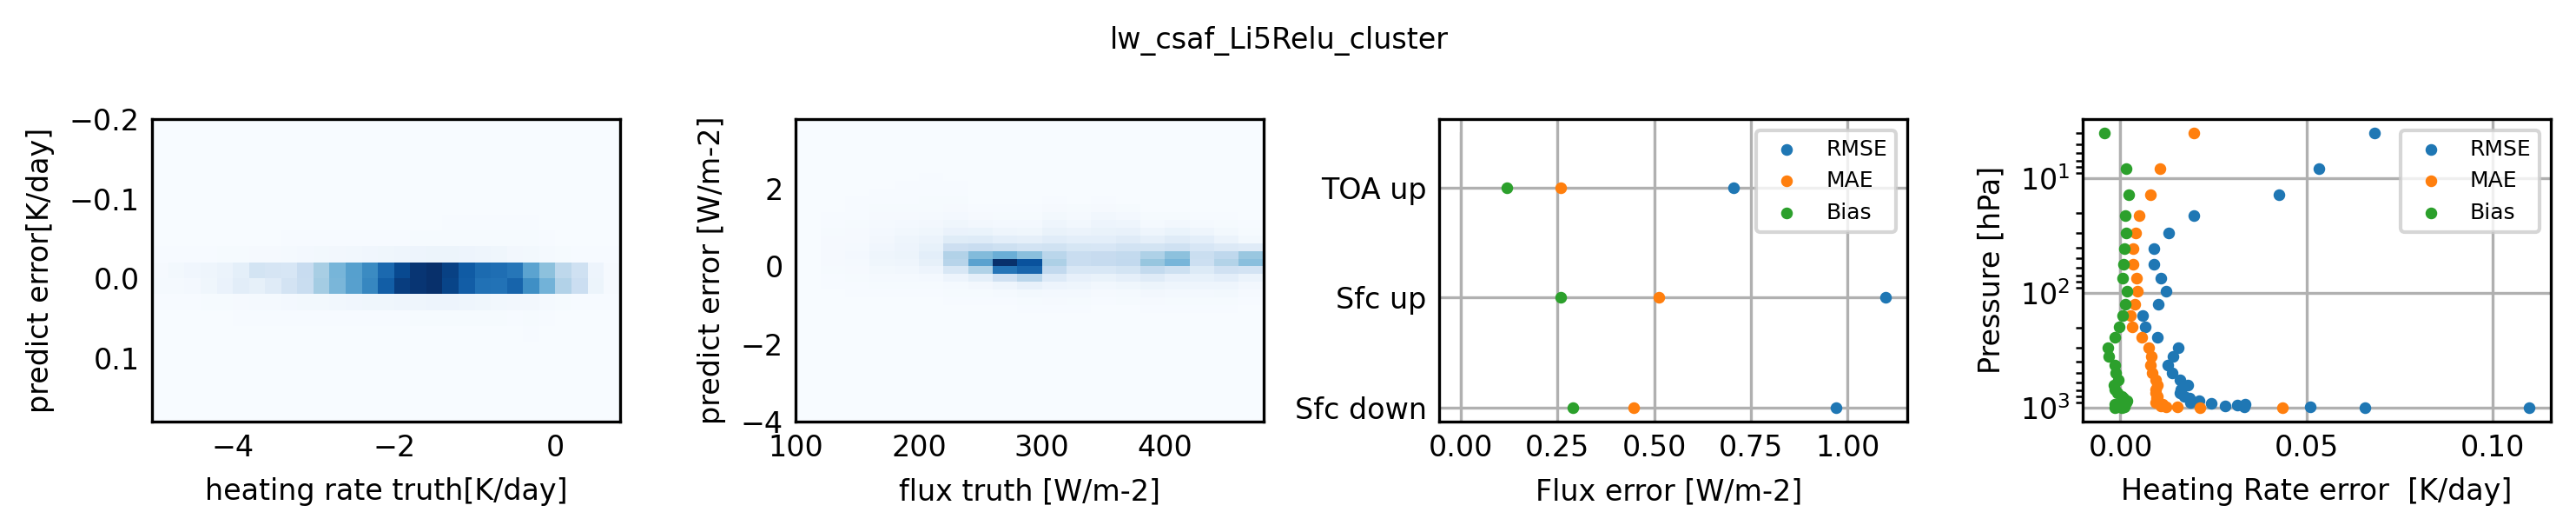

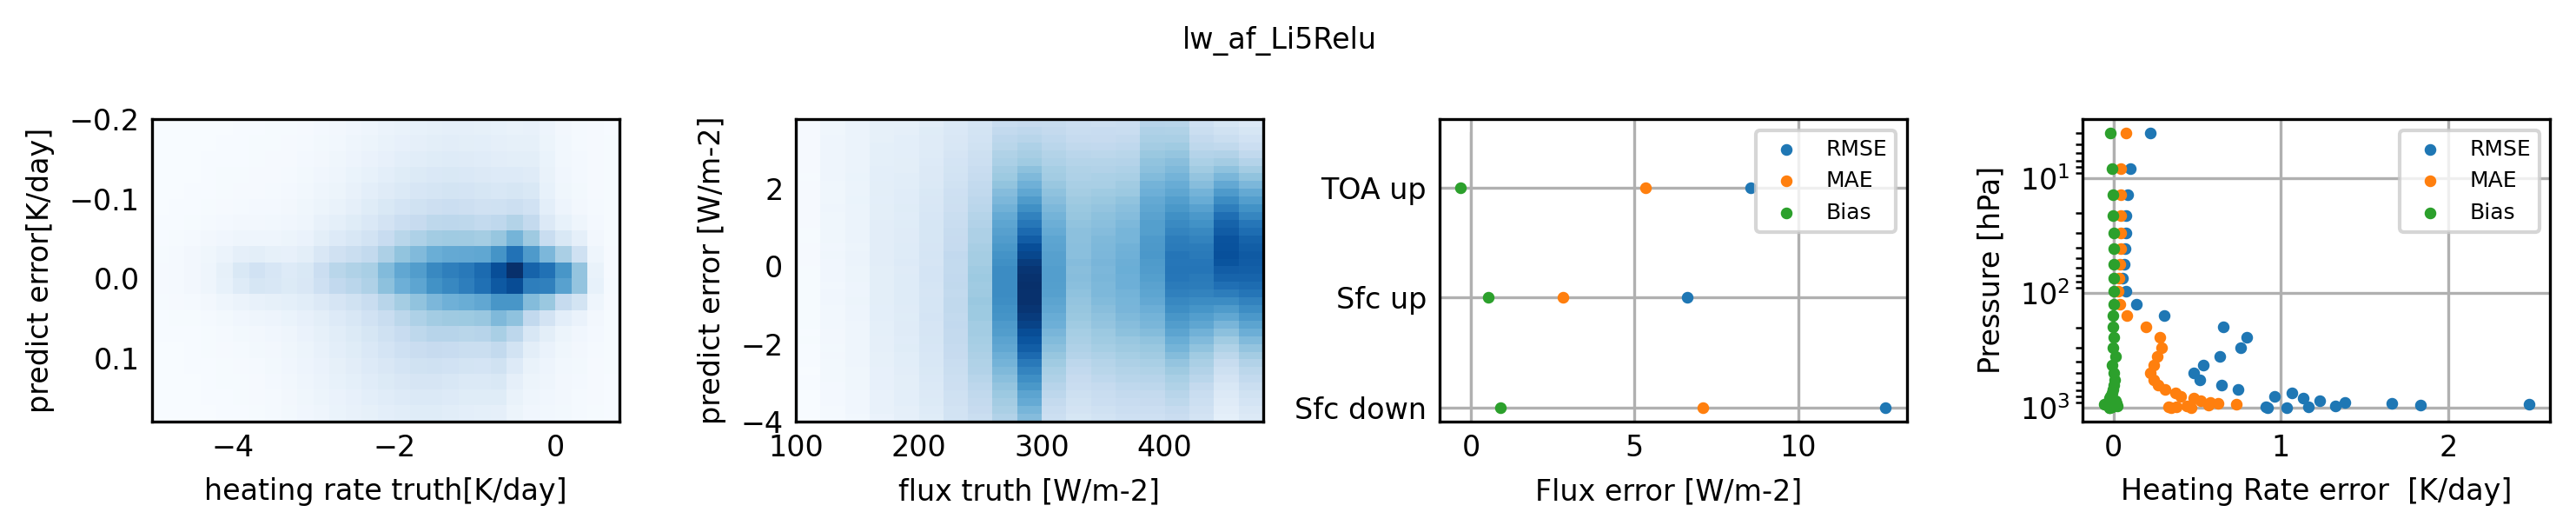

In [10]:
for i, mo in enumerate(Exp_name):
    truth = predi[mo] - error[mo]
    RMSE = ((error[mo]**2).mean(axis=0))**0.5
    MAE  = abs(error[mo]).mean(axis=0)
    bias = error[mo].mean(axis=0)
    plt.style.use('_mpl-gallery')
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10,2),dpi=300) 
    axs=axs.flatten()
    ax1=axs[0] # heating rate
    ax2=axs[1] # surface flux
    ax3=axs[2] # error
    ax4=axs[3] # error
    # ax1.scatter(truth[:,3:].flatten(), bias[:,3:].flatten() , s=1) 
    ax1.hist2d(truth[:,3:].flatten(), error[mo][:,3:].flatten(), bins=(np.arange(-5, 1, 0.2), np.arange(-0.2, 0.2, 0.02)))
    # ax2.scatter(truth[:,:3].flatten(), bias[:,:3].flatten() , s=1) 
    ax2.hist2d(truth[:,:3].flatten(), error[mo][:,:3].flatten(), bins=(np.arange(100, 500, 20), np.arange(-4, 4, 0.2)))

    ax1.invert_yaxis()
    ax1.set_xlabel('heating rate truth[K/day]')
    ax1.set_ylabel('predict error[K/day]')
    ax2.set_xlabel('flux truth [W/m-2]')
    ax2.set_ylabel('predict error [W/m-2]')

    ax3.scatter(RMSE[:3], np.arange(3),  s=5, label='RMSE')
    ax3.scatter(MAE [:3], np.arange(3),  s=5, label='MAE')
    ax3.scatter(bias[:3], np.arange(3),  s=5, label='Bias')
    ax3.plot([0,0],[0,2.5],c='k',linewidth = 0.5, zorder=0)
    ax3.set_yticks([0,1,2], labels=[ 'Sfc down','Sfc up','TOA up',])
    ax3.legend(fontsize=6)
    ax3.set_xlabel('Flux error [W/m-2] ')
#     ax3.set_xlim([-0.1,1.2])

    ax4.scatter(RMSE[3:]  , z_lev[1:],  s=5, label='RMSE')
    ax4.scatter(MAE [3:]  , z_lev[1:],  s=5, label='MAE') 
    ax4.scatter(bias[3:]  , z_lev[1:],  s=5, label='Bias')
    ax4.plot([0,0],[0,1e3],c='k',linewidth = 0.5, zorder=0)
    ax4.legend(fontsize=6)
    ax4.invert_yaxis()
    ax4.set_yscale('log') 
#     ax4.set_xlim([-0.04,0.4])
    ax4.set_xlabel('Heating Rate error  [K/day]')
    ax4.set_ylabel('Pressure [hPa]')
    plt.suptitle(mo,fontsize=8)
    fig.tight_layout()
    fig.show()

In [31]:
[eng_err[mo].mean() for mo in Exp_name]

[0.41359368, 0.1590416]

## exclude large energe error columns

lw_csaf_Li5Relu_cluster good ratio: 1.00
lw_af_Li5Relu good ratio: 0.89


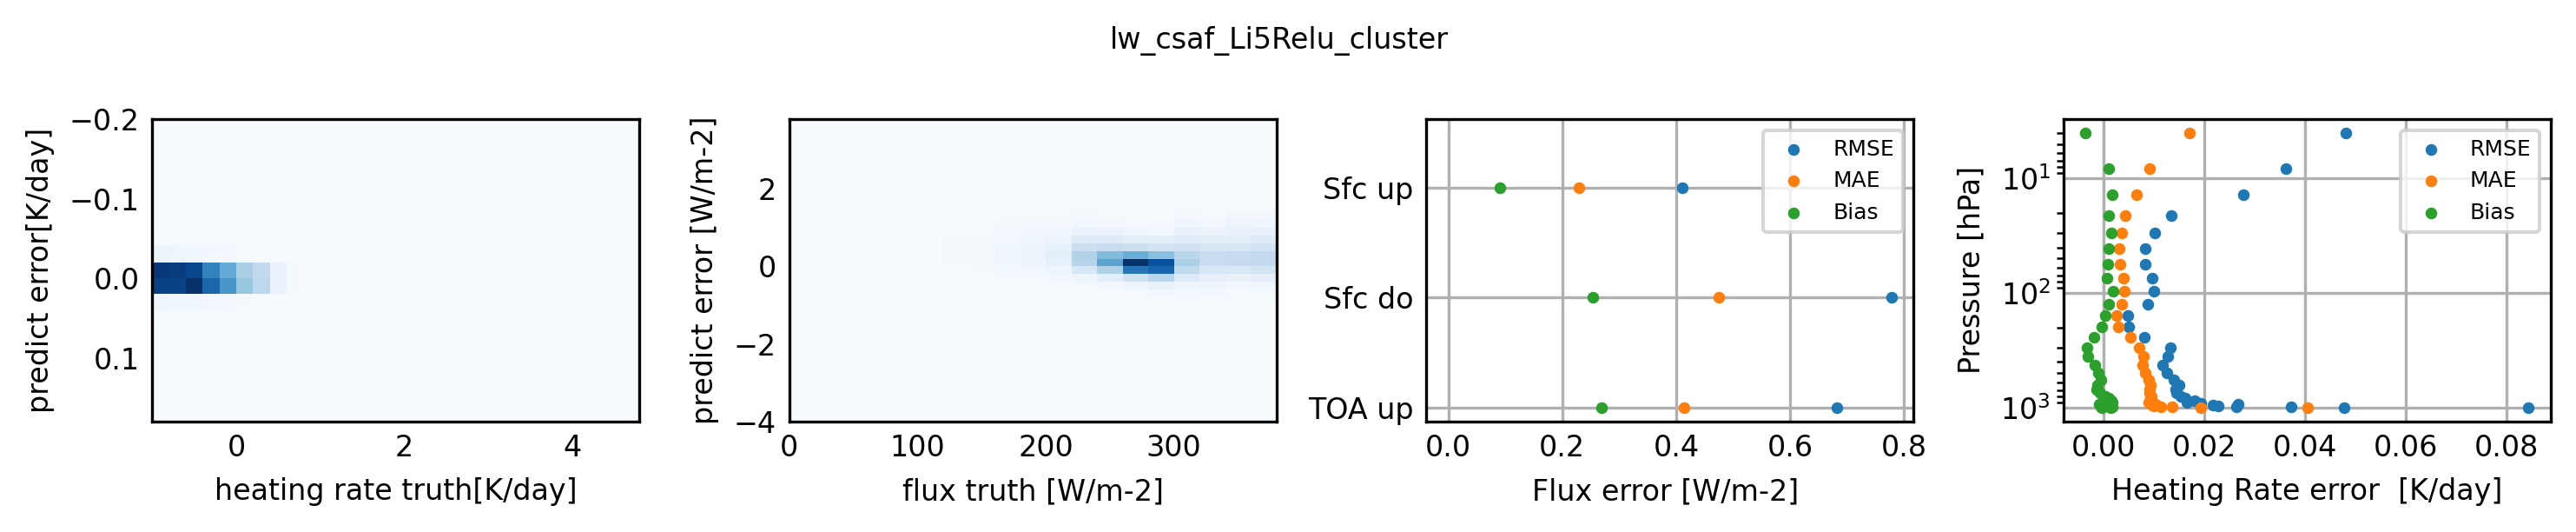

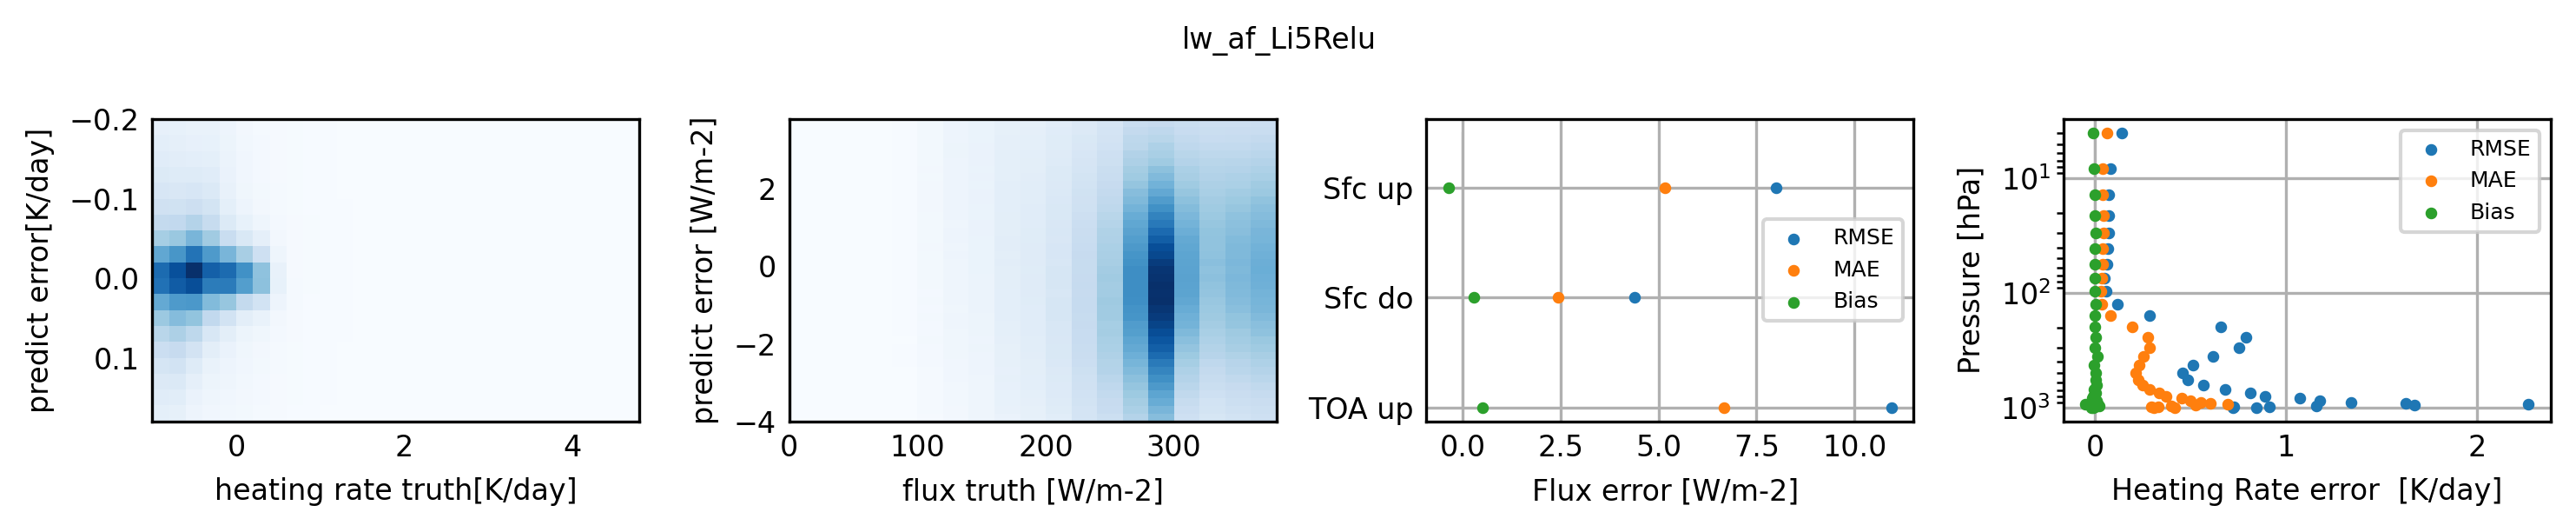

In [29]:
for i, mo in enumerate(Exp_name): 
    ind_small_eng_err = np.argwhere(abs(eng_err[mo])<5)
    print(f'{mo} good ratio: {ind_small_eng_err.shape[0]/eng_err[mo].shape[0]:4.2f}')
    truth = (predi[mo][ind_small_eng_err] - error[mo][ind_small_eng_err]).squeeze()
    RMSE = ((error[mo][ind_small_eng_err,:]**2).mean(axis=0).squeeze())**0.5
    MAE  = abs(error[mo][ind_small_eng_err,:]).mean(axis=0).squeeze()
    bias = error[mo][ind_small_eng_err,:].mean(axis=0).squeeze()
    plt.style.use('_mpl-gallery')
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10,2),dpi=300) 
    axs=axs.flatten()
    ax1=axs[0] # heating rate
    ax2=axs[1] # surface flux
    ax3=axs[2] # error
    ax4=axs[3] # error
    ax1.hist2d(truth[:,3:].flatten(), error[mo][ind_small_eng_err,3:].flatten(), 
               bins=(np.arange(-1, 5, 0.2), np.arange(-0.2, 0.2, 0.02)))
    ax2.hist2d(truth[:,:3].flatten(), error[mo][ind_small_eng_err,:3].flatten(), 
               bins=(np.arange(0, 400, 20), np.arange(-4, 4, 0.2)))

    ax1.invert_yaxis()
    ax1.set_xlabel('heating rate truth[K/day]')
    ax1.set_ylabel('predict error[K/day]')
    ax2.set_xlabel('flux truth [W/m-2]')
    ax2.set_ylabel('predict error [W/m-2]')

    ax3.scatter(RMSE[:3], np.arange(3),  s=5, label='RMSE')
    ax3.scatter(MAE [:3], np.arange(3),  s=5, label='MAE')
    ax3.scatter(bias[:3], np.arange(3),  s=5, label='Bias')
    ax3.plot([0,0],[0,2.5],c='k',linewidth = 0.5, zorder=0)
    ax3.set_yticks([0,1,2], labels=[ 'TOA up','Sfc do','Sfc up',])
    ax3.legend(fontsize=6)
    ax3.set_xlabel('Flux error [W/m-2] ')
#     ax3.set_xlim([-0.1,1.2])
    ax4.scatter(RMSE[3:]  , z_lev[1:],  s=5, label='RMSE')
    ax4.scatter(MAE [3:]  , z_lev[1:],  s=5, label='MAE') 
    ax4.scatter(bias[3:]  , z_lev[1:],  s=5, label='Bias')
    ax4.plot([0,0],[0,1e3],c='k',linewidth = 0.5, zorder=0)
    ax4.legend(fontsize=6)
    ax4.invert_yaxis()
    ax4.set_yscale('log') 
#     ax4.set_xlim([-0.04,0.4])
    ax4.set_xlabel('Heating Rate error  [K/day]')
    ax4.set_ylabel('Pressure [hPa]')
    plt.suptitle(mo,fontsize=8)
    fig.tight_layout()
    fig.show()

# energy check

In [11]:
std_nor = predi[mo].std(axis=0)
pred_err_ind = abs(error[mo]/std_nor).sum(axis=1)

In [12]:
pred_err_ind.shape,eng_err[mo].shape

((5308416,), (5308416,))

In [15]:
rd_id_more = np.random.randint(0,pred_err_ind.shape[0],1000000)

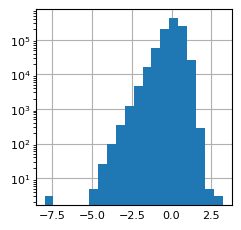

In [26]:
# plt.hist(eng_err[mo][rd_id_more],bins=20)
plt.hist(np.log(abs(eng_err[mo][rd_id_more])+1e-8)/np.log(10),bins=20)
plt.yscale('log')
# plt.xscale('log')

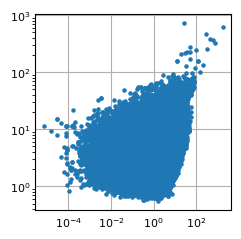

In [21]:
plt.scatter(eng_err[mo][rd_id_more],pred_err_ind[rd_id_more],s=5)
plt.yscale('log')
plt.xscale('log')

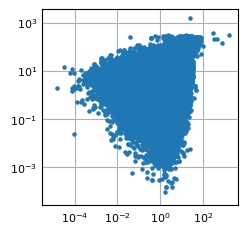

In [22]:
plt.scatter(eng_err[mo][rd_id_more],error[mo][rd_id_more,0],s=5)
plt.yscale('log')
plt.xscale('log')